In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import interp1d
from datetime import datetime, timedelta
from datetime import timezone
import seaborn as sns
sys.path.append('/home/manu/TFG_repo/scripts')

In [4]:
from config import data_dir
from analysis_functions import *
plt.style.use('/home/manu/TFG_repo/notebooks/notebook.mplstyle')


In [115]:
def compare_fit(df_1, df_2, temp, pres, loc):
    temp = if_masked_to_array(temp[loc])
    pres = if_masked_to_array(pres[loc])
    zz = np.linspace(0, pres[-1] + 5, 300)    
    
    fig, ax = plt.subplots(figsize=(4, 4.6875))
    ax.scatter(temp, pres, marker='o', fc='None', ec='tab:red', s=22)
    ax.axhline(df_1.iloc[loc, 3], c='grey', ls='--', label='MLD ref') # plot MLD
    ax.axhline(df_2.iloc[loc, 3], c='grey', ls=':', label='MLD ref new tol') # plot MLD
    ax.set_ylim(pres[-1] + 10, 0)
    ax.set_xlim(9.5, 18)
    ax.plot(fit_function(zz, df_1, loc), zz, ls='--', label='ref')
    ax.plot(fit_function(zz, df_2, loc), zz, label='ref new tol')
    ax.set_xlabel('Temperature (ºC)')
    ax.set_ylabel('Depth (mb)')
    ax.set_title(df_1['Dates'].iloc[loc])
    ax.legend()
    fig.tight_layout()
    plt.show()

def distance(df_fit, variable, n, value):
    '''Given variable of df_fit, return the locs where the diference between
    slices [n:] - [:-n] in that variable are greater than value.
    '''
    array = df_fit[variable].to_numpy()
    locs = np.where(abs(array[n:] - array[:-n]) > value)[0]
    ratio = len(locs)/len(df_fit)
    return locs, ratio
                    
def n_worst_profiles(df_fit, n):
    em = df_fit['em'].to_numpy()
    indices = np.argpartition(em, -n)[-n:]
    return indices

def interpolate(z, y, z_values):
    
    if isinstance(z, np.ma.core.MaskedArray):
        z = np.asarray(z[z.mask==False])
        y = np.asarray(y[y.mask==False])

    if len(z) != len(np.unique(z)):
        idx = np.argmin((z[1:] - z[:-1])) + 1
        z = np.delete(z, idx)
        y = np.delete(y, idx)
         

    interp = interp1d(z, y, 'cubic')
    idx = np.searchsorted(z, z_values)
    y = interp(z_values)
    z = z_values
    return z, y

def find_MLD_directly(temp, pres, delta):
    MLD = []
    zz = np.linspace(1, 175, 350)
    for i in range(len(temp)):
        pres_loc, temp_loc = interpolate(pres[i], temp[i], zz)
        dif = temp_loc[0] - temp_loc
        a = np.searchsorted(dif, delta)
        MLD.append(pres_loc[a])
    return MLD

def plot_interpolation(z, y, z_int, y_int):
    if isinstance(z, np.ma.core.MaskedArray):
        z = np.asarray(z[z.mask==False])
        y = np.asarray(y[y.mask==False])

    fig, ax = plt.subplots(figsize=(4, 4.6875))
    ax.scatter(y, z, marker='o', fc='None', ec='tab:blue', s=22)
    ax.scatter(y_int, z_int, marker='x')
    #ax.plot(y_int, z_int)
    ax.set_ylim(z[-1] + 10, 0)
    ax.set_xlim(9.5, 18)
    ax.set_xlabel('Temperature (ºC)')
    ax.set_ylabel('Depth (mb)')
    fig.tight_layout()
    plt.show()

## Limites b3

(-0.0024423062705465335, 0.0005801601151930822)
0   -0.002332
1   -0.001458
2   -0.002866
3   -0.002584
4   -0.002281
5   -0.003133
Name: b3, dtype: float64


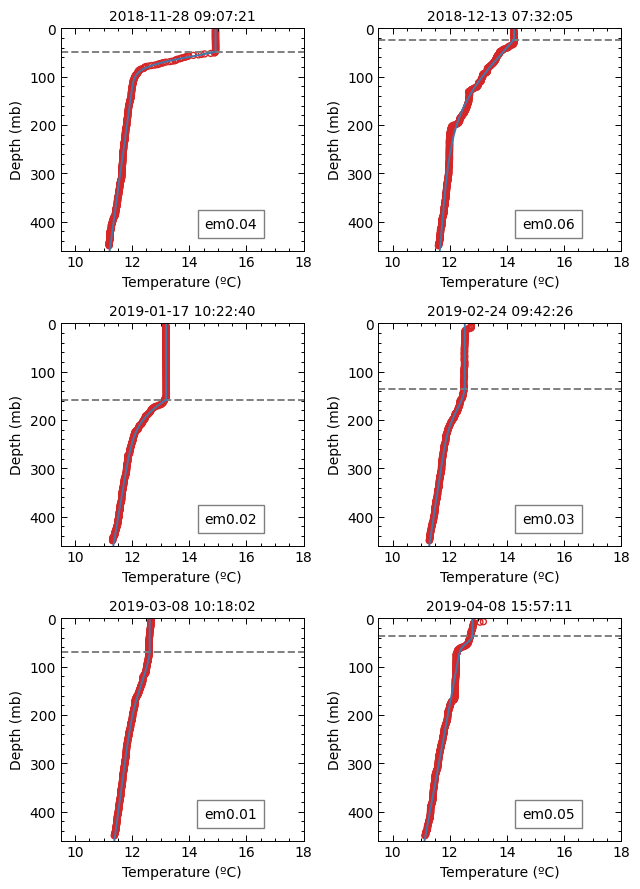

In [148]:
temp_s, pres_s, date_s = load_time_series('station7.nc')
df_station7 = load_SHDR_fit('station7_fit.csv')
print(mean_and_std(df_fit, 'b3'))
print(df_station7['b3'])
plot_multiple_profiles(df_station7, temp_s, pres_s, range(0, len(date_s)))

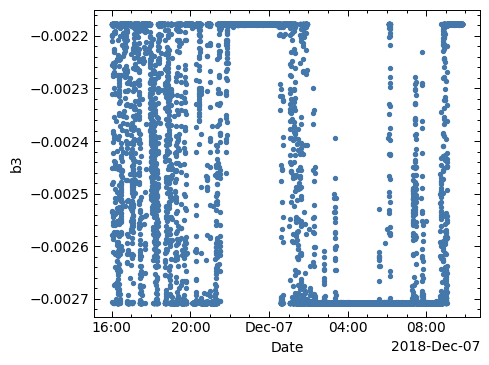

In [149]:
plot_fit_variable(df_cointlin, 'b3')

## Problema perfiles consecutivos

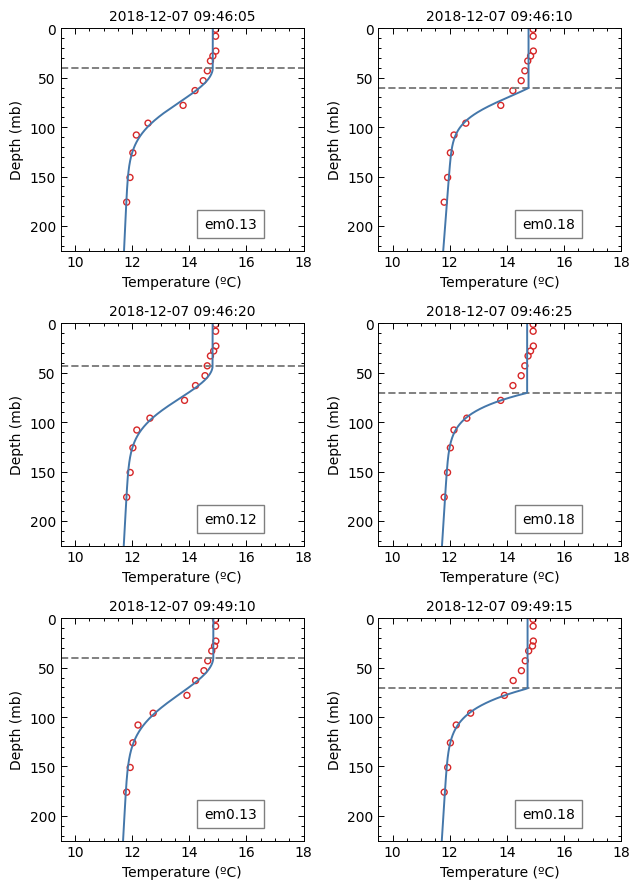

In [155]:
locs, ratio = distance(df_standard, 'D1', 1, 10)
plot_multiple_profiles(df_standard, temp_1, pres_1, locs[-6:])

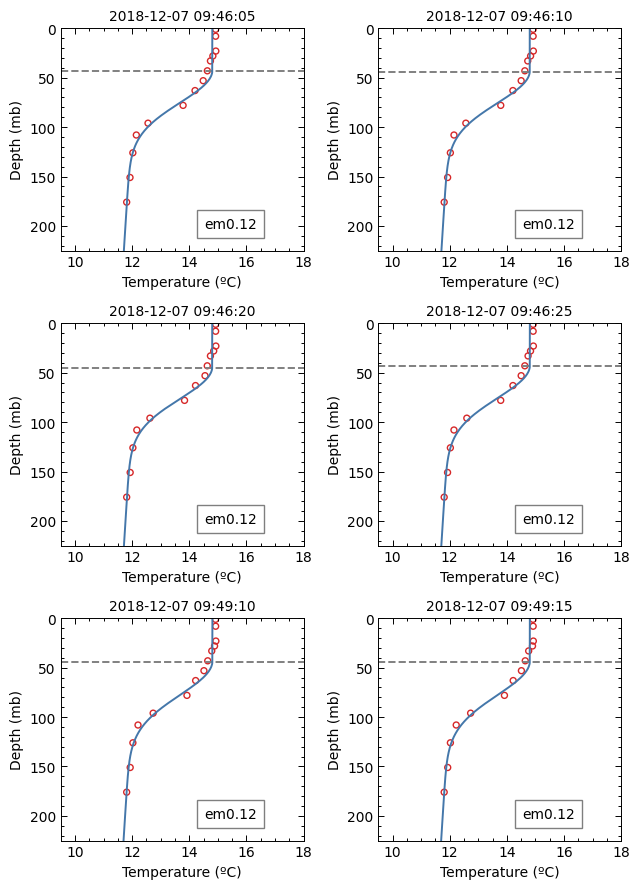

In [235]:
plot_multiple_profiles(df_cointlin, temp_1, pres_1, locs[-6:])

## Interpolaciones

In [258]:
n = 10
y, z = temp_1[n], pres_1[n]
z_int = np.array([13, 18, 38, 58, 68, 73, 87])
_, y_int = interpolate(z, y, z_int)

z_intmore = np.array([13, 18, 25.5, 36, 39, 46, 56.3, 59.6, 68, 73, 82, 89, 102, 117, 139.5, 163.5])
_, y_intmore = interpolate(z, y, z_intmore)

z_intlin = [13, 18, 38, 48, 58, 68, 73, 84, 90, 102, 114, 120, 131, 136, 141, 146, 156, 161, 166, 171]
_, y_intlin = interpolate(z, y, z_intlin)

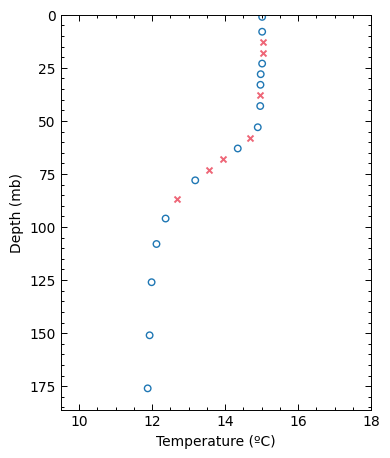

In [259]:
plot_interpolation(z, y, z_int, y_int)

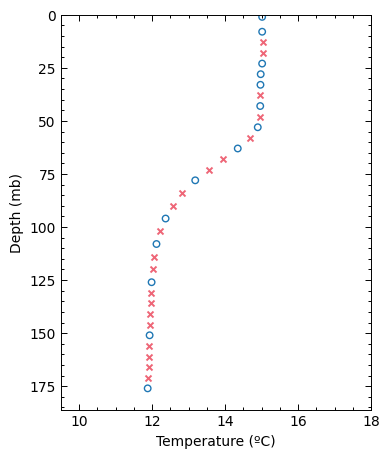

In [260]:
plot_interpolation(z, y, z_intlin, y_intlin)

### Early winter

In [6]:
temp_1, pres_1, date_1 = load_time_series('test/test_1.nc')

In [251]:
df_coint = load_SHDR_fit('SHDR_trials/test_int.csv')
df_co = load_SHDR_fit('SHDR_trials/test_no_int.csv')
df_cointlin = load_SHDR_fit('SHDR_trials/test_int_linspaced.csv')
df_int = load_SHDR_fit('SHDR_trials/test_int_linspaced_no_c.csv')
df_standard = load_SHDR_fit('SHDR_trials/test_standard.csv')
df_10 = load_SHDR_fit('SHDR_trials/test_int_lins_low_b3.csv')


In [252]:
print(mean_and_std(df_cointlin, 'em'))
print(mean_and_std(df_standard, 'em'))

(0.06972111455744762, 0.026085462609138736)
(0.07511293667659731, 0.027647025453454065)


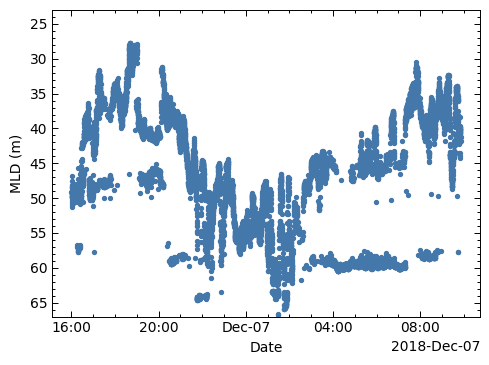

In [253]:
fig, ax = plot_fit_variable(df_standard, 'D1', plot=False)
ax.set_ylim(67, 23)
fig.tight_layout()
plt.show()

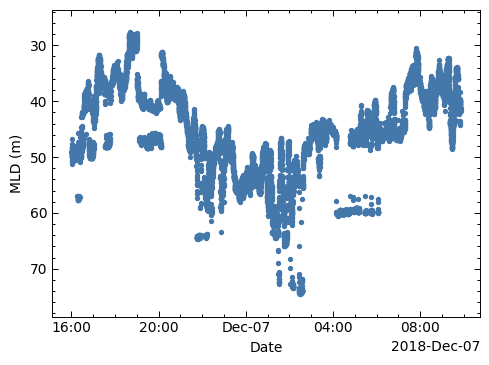

In [254]:
plot_fit_variable(df_co, 'D1')

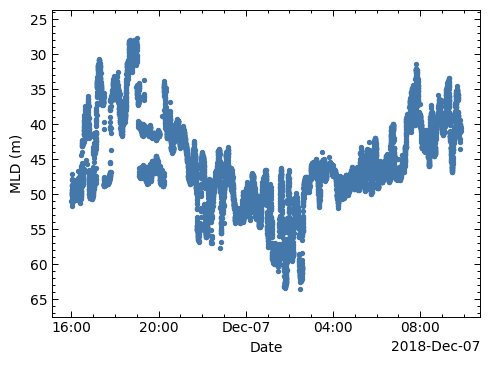

In [28]:
plot_fit_variable(df_coint, 'D1')

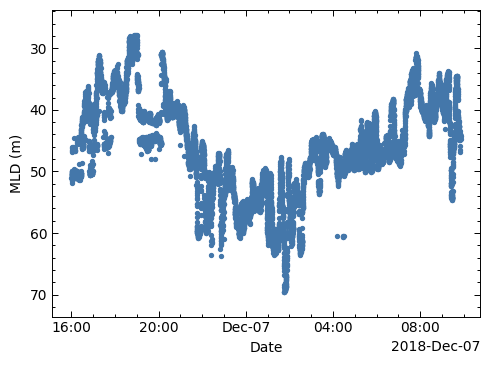

In [30]:
plot_fit_variable(df_cointlin, 'D1')

In [46]:
mld_delta = find_MLD_directly(temp_1, pres_1, 0.2)

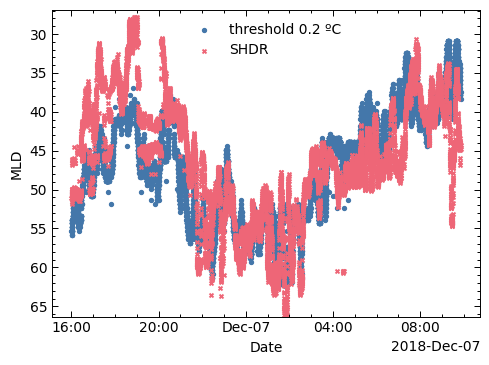

In [256]:
fig, ax = plt.subplots()
ax.scatter(date_1, mld_delta, s=8, marker='o', label='threshold 0.2 ºC')
ax.scatter(date_1, df_cointlin['D1'], s=8, marker='x', label='SHDR')
ax.set_xlabel('Date')
ax.set_ylabel('MLD')
ax.legend()
ax.set_ylim((max(mld_delta) + 4, min(mld_delta) - 4))
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
fig.tight_layout()
plt.show()

4.132005771820452 2.94430619618915


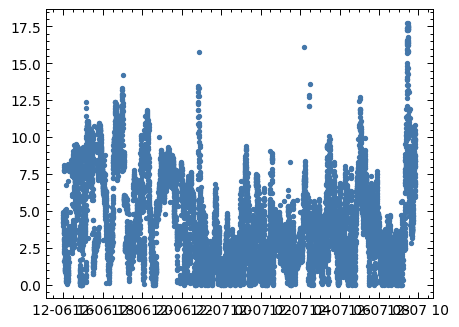

In [257]:
fig, ax = plt.subplots()
ax.scatter(date_1, abs(mld_delta - df_cointlin['D1']), s=8)
print(np.mean(abs(mld_delta - df_cointlin['D1'])), np.std(abs(mld_delta - df_cointlin['D1'])))


In [142]:
# distances
d = 10
print(f'Ratio de perfiles contiguos con una diferencia en D1 de más de {d} metros')
print('standard: {:.5f}'.format(distance(df_standard, 'D1', 1, d)[1]))
print('co: {:.5f}'.format(distance(df_co, 'D1', 1, d)[1]))
print('cointlin: {:5f}'.format(distance(df_cointlin, 'D1', 1, d)[1]))
print('coint: {:5f}'.format(distance(df_coint, 'D1', 1, d)[1]))

Ratio de perfiles contiguos con una diferencia en D1 de más de 10 metros
standard: 0.23094
co: 0.00311
cointlin: 0.000856
coint: 0.000000


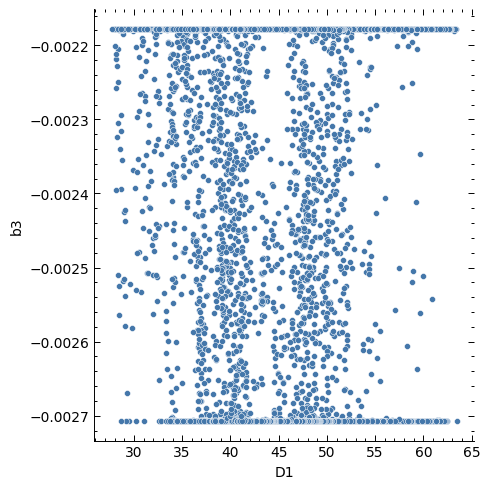

In [84]:
sns.relplot(
    data=df_coint, kind="scatter",
    x="D1", y="b3",
)
plt.show()

In [214]:
def normal_vs_interpolated_RMS(df_fit, temp, pres, z_int, loc):
    y = if_masked_to_array(temp[loc])
    z = if_masked_to_array(pres[loc])
    z_int, y_int = interpolate(z, y, z_int)
    idx = np.searchsorted(z, z_int)
    z_complete = np.insert(z, idx, z_int)
    y_complete = np.insert(y, idx, y_int)
    fitnes = np.sqrt(np.sum((y - fit_function(z, df_fit, loc))**2) / len(y))
    interpolated_fitnes = np.sqrt(np.sum((y_complete - fit_function(z_complete, df_fit, loc))**2) / len(y_complete))
    return fitnes, interpolated_fitnes


In [239]:
z_int = [13, 18, 38, 48, 58, 68, 73, 84, 90, 102, 114, 120, 131, 136, 141, 146, 156, 161, 166, 171]

dif_em = []
for i in range(len(date_1)):
    if (normal_vs_interpolated_RMS(df_coint, temp_1, pres_1, z_int, i)[0] > df_co.loc[i, 'em']):
        dif_em.append(i)

In [240]:
print(len(dif_em)/len(date_1))
print(normal_vs_interpolated_RMS(df_cointlin, temp_1, pres_1, z_int, 0))

0.9884842826019297
(0.020310203645996495, 0.017292055372503036)


## Winter

In [242]:
temp_2, pres_2, date_2 = load_time_series('test/test_winter.nc')